In [2]:
import torch
from torch import nn
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import numpy as np

from torchinfo import summary


In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
print(torch.cuda.get_device_name())

cuda:0
NVIDIA GeForce RTX 3060 Laptop GPU


#### Download CIFAR10 dataset

In [4]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


#### Show image data

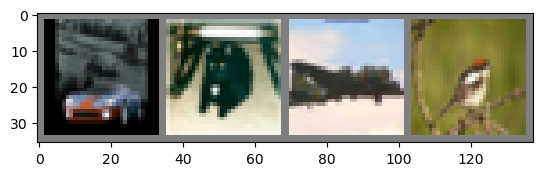

car   cat   plane bird 


In [5]:
# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)
images, labels = next(dataiter)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

#### Load pretrained vgg16_bn model with pretrained weight(trained to IMAGENET dataset)

In [76]:
model = torchvision.models.vgg11_bn(weights="IMAGENET1K_V1")

#### Modify model to classify CIFAR10 dataset

Modify classifier to output 10 dimension

In [77]:
# change model classifier to output 
model.classifier = nn.Sequential(
    nn.Linear(in_features=25088, out_features=10, bias=True),
)
# initialize weight(xavier initialization)
torch.nn.init.xavier_normal_(model.classifier[0].weight)
intermediate_params = []
last_params = []
for name, para in model.named_parameters():
    if name in ["features.11.weight",
                "features.11.bias",
                "features.12.weight",
                "features.12.bias",
                "features.15.weight",
                "features.15.bias",
                "features.16.weight",
                "features.16.bias",
                "features.18.weight",
                "features.18.bias",
                "features.19.weight",
                "features.19.bias",
                "features.22.weight",
                "features.22.bias",
                "features.23.weight",
                "features.23.bias",
                "features.25.weight",
                "features.25.bias"
                "features.26.weight"
                "features.26.bias"
                ]:
        print("feature abstraction layer:", name)
        para.requires_grad = True
        intermediate_params.append(para)
    elif "classifier" in name:
        print("classifier layer:", name)
        para.requires_grad = True
        last_params.append(para)
    else:
        print("non trainable layer:", name)
        para.requires_grad = False

summary(model)
# we can check that trainable parameters changed from 5132868840 -> 8263168

non trainable layer: features.0.weight
non trainable layer: features.0.bias
non trainable layer: features.1.weight
non trainable layer: features.1.bias
non trainable layer: features.4.weight
non trainable layer: features.4.bias
non trainable layer: features.5.weight
non trainable layer: features.5.bias
non trainable layer: features.8.weight
non trainable layer: features.8.bias
non trainable layer: features.9.weight
non trainable layer: features.9.bias
feature abstraction layer: features.11.weight
feature abstraction layer: features.11.bias
feature abstraction layer: features.12.weight
feature abstraction layer: features.12.bias
feature abstraction layer: features.15.weight
feature abstraction layer: features.15.bias
feature abstraction layer: features.16.weight
feature abstraction layer: features.16.bias
feature abstraction layer: features.18.weight
feature abstraction layer: features.18.bias
feature abstraction layer: features.19.weight
feature abstraction layer: features.19.bias
feat

Layer (type:depth-idx)                   Param #
VGG                                      --
├─Sequential: 1-1                        --
│    └─Conv2d: 2-1                       (1,792)
│    └─BatchNorm2d: 2-2                  (128)
│    └─ReLU: 2-3                         --
│    └─MaxPool2d: 2-4                    --
│    └─Conv2d: 2-5                       (73,856)
│    └─BatchNorm2d: 2-6                  (256)
│    └─ReLU: 2-7                         --
│    └─MaxPool2d: 2-8                    --
│    └─Conv2d: 2-9                       (295,168)
│    └─BatchNorm2d: 2-10                 (512)
│    └─ReLU: 2-11                        --
│    └─Conv2d: 2-12                      590,080
│    └─BatchNorm2d: 2-13                 512
│    └─ReLU: 2-14                        --
│    └─MaxPool2d: 2-15                   --
│    └─Conv2d: 2-16                      1,180,160
│    └─BatchNorm2d: 2-17                 1,024
│    └─ReLU: 2-18                        --
│    └─Conv2d: 2-19         

#### Train last fully-connected-layer(classifier) with cifar 10 dataset

In [78]:
criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam([{'params': last_params, 'lr': 1e-3},
#                         {'params': intermediate_params, 'lr': 1e-3}])
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [79]:
model = model.to(device)
for epoch in range(10):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        # change data: inputs and labels tenosrs to cuda
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 500 == 499:    # print every 500 mini-batches (batch size: 4 from dataloader)
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 500:.3f}')
            running_loss = 0.0

print('Finished Training')

[1,   500] loss: 2.396
[1,  1000] loss: 2.088
[1,  1500] loss: 2.019
[1,  2000] loss: 1.865
[1,  2500] loss: 1.790
[1,  3000] loss: 1.628
[1,  3500] loss: 1.720
[1,  4000] loss: 1.602
[1,  4500] loss: 1.624
[1,  5000] loss: 1.510
[1,  5500] loss: 1.432
[1,  6000] loss: 1.350
[1,  6500] loss: 1.350
[1,  7000] loss: 1.283
[1,  7500] loss: 1.238
[1,  8000] loss: 1.207
[1,  8500] loss: 1.169
[1,  9000] loss: 1.131
[1,  9500] loss: 1.116
[1, 10000] loss: 1.092
[1, 10500] loss: 1.095
[1, 11000] loss: 1.028
[1, 11500] loss: 1.019
[1, 12000] loss: 1.000
[1, 12500] loss: 0.967
[2,   500] loss: 0.924
[2,  1000] loss: 0.898
[2,  1500] loss: 0.964
[2,  2000] loss: 0.944
[2,  2500] loss: 0.916
[2,  3000] loss: 0.905
[2,  3500] loss: 0.859
[2,  4000] loss: 0.831
[2,  4500] loss: 0.860
[2,  5000] loss: 0.794
[2,  5500] loss: 0.841
[2,  6000] loss: 0.855
[2,  6500] loss: 0.878
[2,  7000] loss: 0.748
[2,  7500] loss: 0.878
[2,  8000] loss: 0.841
[2,  8500] loss: 0.873
[2,  9000] loss: 0.847
[2,  9500] 

In [80]:
# save pytorch data
PATH = './cifar_net.pth'
print(model.state_dict())
torch.save(model.state_dict(), PATH)

OrderedDict([('features.0.weight', tensor([[[[-5.9550e-01, -8.3957e-01, -5.1592e-01],
          [ 4.3290e-02, -5.4894e-02, -1.9865e-01],
          [ 6.0978e-01,  9.1177e-01,  6.1916e-01]],

         [[-9.0904e-01, -1.3191e+00, -8.8276e-01],
          [ 7.5378e-02,  6.8023e-03, -1.9233e-01],
          [ 8.9835e-01,  1.3841e+00,  9.1575e-01]],

         [[-3.8599e-01, -6.1602e-01, -3.4967e-01],
          [ 1.3486e-02,  3.0266e-02, -1.0543e-01],
          [ 3.4950e-01,  6.8686e-01,  3.9954e-01]]],


        [[[ 1.0105e-05, -5.7597e-07,  3.7357e-05],
          [ 2.3276e-05, -2.6341e-05,  2.4588e-05],
          [ 3.2592e-05, -8.7637e-06,  1.0022e-05]],

         [[-5.1987e-06, -1.5983e-05,  3.5566e-05],
          [ 1.8771e-05, -3.9012e-05,  2.3113e-05],
          [ 3.8826e-05, -8.0352e-06,  1.5741e-05]],

         [[-2.1435e-06, -9.3418e-06,  2.5209e-05],
          [ 1.3776e-05, -3.0619e-05,  1.3845e-05],
          [ 2.6642e-05, -9.2021e-06,  6.2266e-06]]],


        [[[ 1.8067e-01,  2.5138

Test the network on the test data

In [ ]:
model = model
model.load_state_dict(torch.load(PATH))

for param in model.parameters():
    param = param.to(device)

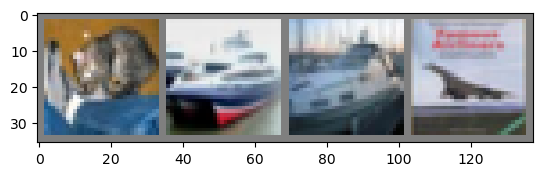

GroundTruth:  cat   ship  ship  plane


In [89]:
dataiter = iter(testloader)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

images = images.to(device)
labels = labels.to(device)

In [90]:
outputs = model(images)

In [91]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(4)))

Predicted:  cat   ship  car   plane


In [93]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        # calculate outputs by running images through the network
        outputs = model(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 80 %
